# Lab 2. LLM Quantization Lab

This lab source is partly based on

- EfficientML.ai Lab https://hanlab.mit.edu/courses/2023-fall-65940
- KoAlpaca+GPTQ git https://github.com/qwopqwop200/GPTQ-for-KoAlpaca



Updated by Geonho Lee, Sungwan Ryu 2024.8.25

Created by Minsoo Kim 2023.11.03

## Part1. LLM Quantization with GPTQ, AWQ, and NF4

### Package pip install & import (~3m)

In [1]:
print('Installing packages...')
!pip install -U git+https://github.com/huggingface/transformers.git
!pip install -U git+https://github.com/huggingface/accelerate.git
!pip install datasets
!pip install torch tqdm
!pip install autoawq
!pip install transformers
!pip install -U auto-gptq optimum
!pip install --upgrade torchvision

Installing packages...
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-ysx5p_zb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-ysx5p_zb
  Resolved https://github.com/huggingface/transformers.git to commit f42084e6411c39b74309af4a7d6ed640c01a4c9e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10283310 sha256=24821474feb141dd54333541d41f50a1a615f2e5bed16383a661a66f6ddeb6f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-4d2mbobx/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
  Cl

#### 런타임 - 세션 다시 시작

In [1]:
# Import Libraries
import tqdm
import torch
from torch import nn
from transformers import AutoModelForCausalLM, AutoTokenizer, GPTQConfig, BitsAndBytesConfig
import datasets
from datasets import load_dataset
from functools import partial
import gc
import copy

In [2]:
# Set evaluation
import tqdm
def evaluate(model, tokenizer):
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))


### Part1-0. FP Model

Let's build and load small language model (OPT-125m) on GPU

In [3]:
model_path = "facebook/opt-350m"

In [4]:
model_path = "facebook/opt-350m"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
fp_model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")
for para in fp_model.parameters():
    para.requires_grad = False
fp_model.config.use_cache = False
fp_model.eval()
gc.collect()
torch.cuda.empty_cache()
print(fp_model)
print(f"Parameter data type: {fp_model.dtype}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features

In [5]:
layer_number = 2 # number of layer
fp_model.model.decoder.layers[layer_number].self_attn.k_proj.weight[0][:8]

tensor([ 0.0015,  0.0075,  0.0167,  0.0334,  0.0093, -0.0170, -0.0083,  0.0023],
       device='cuda:0')

In [6]:
fp_model_memory = 0

In [7]:
# Evaluate the model
fp_model_perplexity = evaluate(fp_model, tokenizer)
print(f"\nFP model perplexity: {fp_model_perplexity:.2f}")
gc.collect()
torch.cuda.empty_cache()

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/662M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/733k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.36M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

evaluating...: 100%|██████████| 40/40 [00:08<00:00,  4.95it/s]



FP model perplexity: 21.91


In [8]:
fp_model_ppl = 0

### Part1-4. Pruning

In [76]:
# Import Libraries
import tqdm
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from functools import partial
from torch.optim import AdamW
import gc
import copy

# Load model and tokenizer
model_path = "facebook/opt-350m"
tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)
model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto")

In [81]:
for para in model.parameters():
    para.requires_grad = False

model.config.use_cache = False
model.eval()
gc.collect()
torch.cuda.empty_cache()

print(model)
print(f"Parameter data type: {model.dtype}")

def prune_weights(model, pruning_percentage):
    """
    Prunes the model's weights using magnitude-based pruning.

    Parameters:
        model (nn.Module): The pre-trained model to be pruned.
        pruning_percentage (float): The percentage of weights to prune (0 to 100).

    Returns:
        nn.Module: The pruned model.
    """
    total_params = 0
    pruned_params = 0

    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name and param.requires_grad:

                # Flatten the weight tensor
                weight_data = param.data.view(-1)

                # Calculate the k-th smallest value for pruning threshold
                k = int(pruning_percentage / 100 * weight_data.numel())
                if k == 0:  # No pruning if k is 0
                    continue

                # Get the threshold value for pruning
                threshold = torch.topk(weight_data.abs(), k, largest=False).values.max()

                # Mask for pruning (set values below threshold to zero)
                mask = torch.abs(param.data) >= threshold
                pruned_params += param.numel() - mask.sum().item()
                param.data *= mask  # Apply the mask to the weight
                total_params += param.numel()

    pruning_ratio = pruned_params / total_params * 100 if total_params > 0 else 0
    print(f"Total parameters: {total_params}")
    print(f"Pruned parameters: {pruned_params}")
    print(f"Actual pruning ratio: {pruning_ratio:.2f}%")

    return model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features

In [82]:
def evaluate_pruned_model(model, tokenizer):
    """
    Calculates the perplexity of the pruned model on the Wikitext-2 dataset.

    Parameters:
        model (nn.Module): The pruned model.
        tokenizer (transformers.Tokenizer): The tokenizer for the model.

    Returns:
        float: The perplexity of the model on Wikitext-2.
    """
    testenc = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
    testenc = tokenizer("\n\n".join(testenc['text']), return_tensors='pt')

    testenc = testenc.input_ids.to(model.device)
    nsamples = 40
    model = model.eval()

    nlls = []
    for i in tqdm.tqdm(range(nsamples), desc="evaluating..."):
        batch = testenc[:, (i * 2048):((i + 1) * 2048)].to(model.device)
        with torch.no_grad():
            lm_logits = model(batch).logits
        shift_logits = lm_logits[:, :-1, :].contiguous().float()
        shift_labels = testenc[:, (i * 2048):((i + 1) * 2048)][:, 1:]
        loss_fct = nn.CrossEntropyLoss()
        try:
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        except ZeroDivisionError:
            print("Warning: Division by zero occurred during loss calculation. Skipping this batch.")
            continue

        neg_log_likelihood = loss.float() * 2048
        nlls.append(neg_log_likelihood)

    if len(nlls) == 0:
        print("Warning: No valid batches processed. Perplexity cannot be calculated.")
        return float('inf')

    return torch.exp(torch.stack(nlls).sum() / (nsamples * 2048))

In [93]:
def main():
    pruning_percentage = 50  # 프루닝 비율 (%)

    print(f"{pruning_percentage}% 비율로 프루닝 시작")
    pruned_model = prune_weights(model, pruning_percentage)

    print("Perplexity 계산 중... (Wikitext-2 데이터셋)")
    pruned_perplexity = evaluate_pruned_model(pruned_model, tokenizer)
    print(f"Pruned 모델의 Perplexity (Wikitext-2): {pruned_perplexity}")

    return pruned_model, tokenizer, pruned_perplexity  # pruned_model과 tokenizer 반환

if __name__ == "__main__":
    pruned_model, tokenizer, pruned_ppl = main()  # 반환값을 전역 변수로 정의

50% 비율로 프루닝 시작
Total parameters: 0
Pruned parameters: 0
Actual pruning ratio: 0.00%
Perplexity 계산 중... (Wikitext-2 데이터셋)


evaluating...: 100%|██████████| 40/40 [02:03<00:00,  3.08s/it]

Pruned 모델의 Perplexity (Wikitext-2): 21.908035278320312


In [88]:
    # Save and reload the pruning model to ensure the state is consistent
    pruned_model.to('cpu').save_pretrained("opt-350m-pruned")
    tokenizer.save_pretrained("opt-350m-pruned")

    # Load the saved pruned model
    pruned_model = AutoModelForCausalLM.from_pretrained("opt-350m-pruned", device_map="auto")
    tokenizer = AutoTokenizer.from_pretrained("opt-350m-pruned", use_fast=False)

In [90]:
    # Apply GPTQ to pruned model
    print("Applying GPTQ quantization to pruned model...")
    quantization_config = GPTQConfig(bits=4, dataset="c4", tokenizer=tokenizer)
    gptq_model = AutoModelForCausalLM.from_pretrained(
        "opt-350m-pruned",
        device_map="auto",
        quantization_config=quantization_config
    )
    for param in gptq_model.parameters():
        param.requires_grad = False
    gptq_model.config.use_cache = False
    gptq_model.eval()

    print("Perplexity 계산 중... (Wikitext-2 데이터셋)")
    gptq_perplexity = evaluate_pruned_model(gptq_model, tokenizer)
    print(f"GPTQ 모델의 Perplexity (Wikitext-2): {gptq_perplexity}")


Applying GPTQ quantization to pruned model...


Quantizing model.decoder.layers blocks :   0%|          | 0/24 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:5057: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Perplexity 계산 중... (Wikitext-2 데이터셋)


evaluating...: 100%|██████████| 40/40 [00:02<00:00, 15.99it/s]

GPTQ 모델의 Perplexity (Wikitext-2): 23.27410888671875


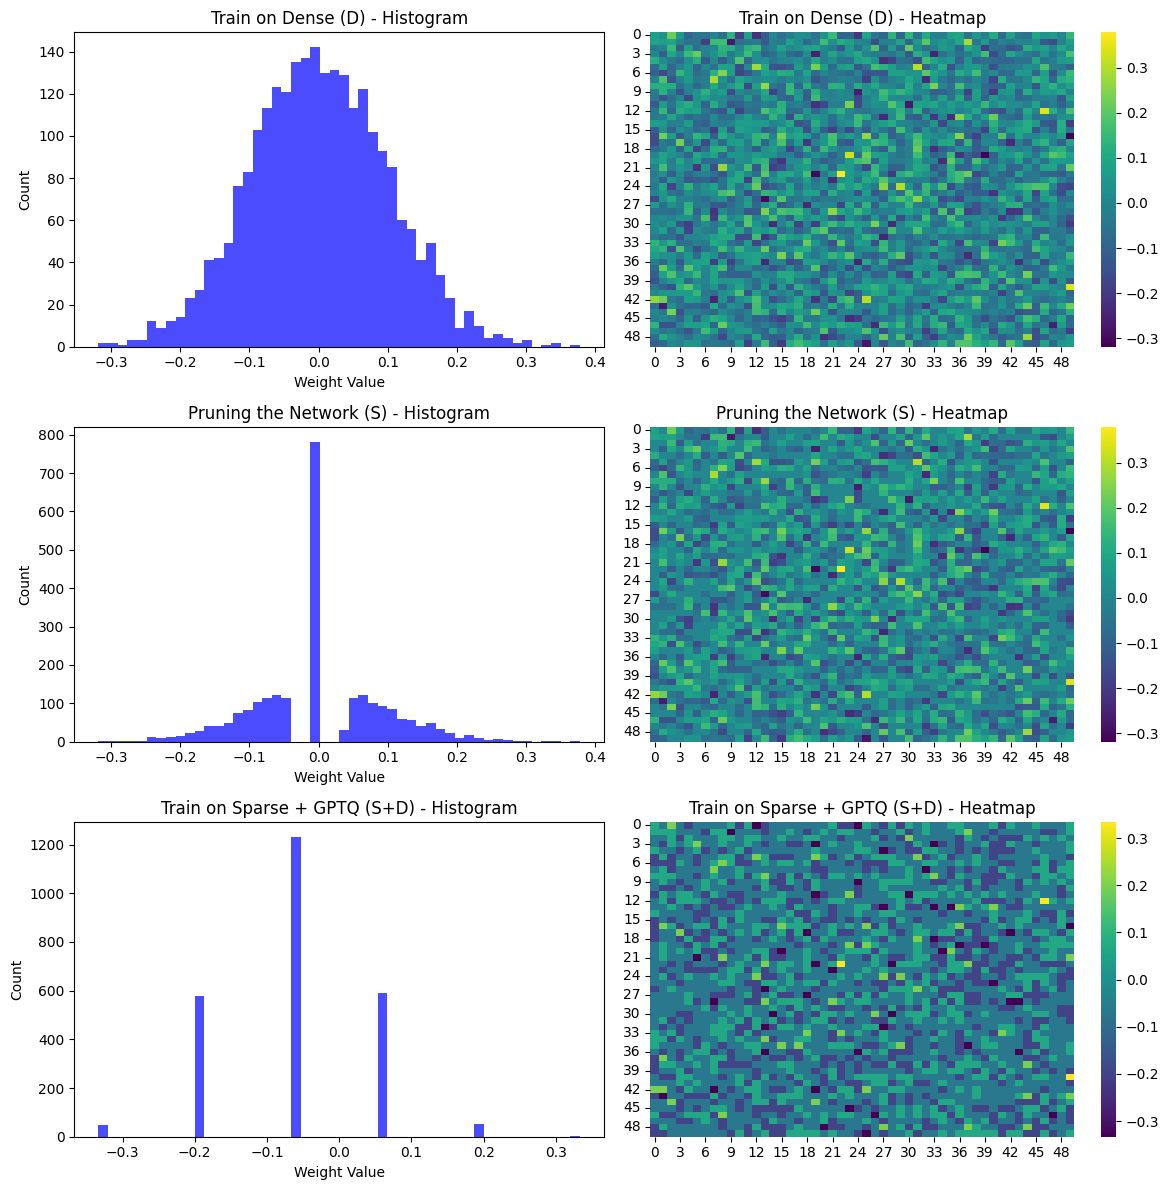

In [73]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import gc

# Helper function to plot histograms and heatmaps of weights
def plot_weight_distributions(baseline_weights, pruned_weights, gptq_weights):
    """
    Plots histograms and heatmaps for weights of Baseline, Pruned, and Pruned + GPTQ models.

    Parameters:
    - baseline_weights (torch.Tensor): Weights of the baseline model.
    - pruned_weights (torch.Tensor): Weights of the pruned model.
    - gptq_weights (torch.Tensor): Weights of the pruned + GPTQ model.
    """
    # Flatten weights for histograms
    baseline_flat = baseline_weights.flatten()
    pruned_flat = pruned_weights.flatten()
    gptq_flat = gptq_weights.flatten()

    plt.figure(figsize=(12, 12))

    # Baseline - Histogram
    plt.subplot(3, 2, 1)
    plt.hist(baseline_flat, bins=50, color='blue', alpha=0.7)
    plt.title("Train on Dense (D) - Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Count")

    # Baseline - Heatmap
    plt.subplot(3, 2, 2)
    sns.heatmap(baseline_weights, cmap='viridis', cbar=True)
    plt.title("Train on Dense (D) - Heatmap")

    # Pruned - Histogram
    plt.subplot(3, 2, 3)
    plt.hist(pruned_flat, bins=50, color='blue', alpha=0.7)
    plt.title("Pruning the Network (S) - Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Count")

    # Pruned - Heatmap
    plt.subplot(3, 2, 4)
    sns.heatmap(pruned_weights, cmap='viridis', cbar=True)
    plt.title("Pruning the Network (S) - Heatmap")

    # Pruned + GPTQ - Histogram
    plt.subplot(3, 2, 5)
    plt.hist(gptq_flat, bins=50, color='blue', alpha=0.7)
    plt.title("Train on Sparse + GPTQ (S+D) - Histogram")
    plt.xlabel("Weight Value")
    plt.ylabel("Count")

    # Pruned + GPTQ - Heatmap
    plt.subplot(3, 2, 6)
    sns.heatmap(gptq_weights, cmap='viridis', cbar=True)
    plt.title("Train on Sparse + GPTQ (S+D) - Heatmap")

    plt.tight_layout()
    plt.show()

# Ensure memory is clear
gc.collect()

# Simulated models for demonstration
baseline_model = torch.nn.Linear(50, 50)  # Model size is 50x50
pruned_model = torch.nn.Linear(50, 50)
gptq_model = torch.nn.Linear(50, 50)

with torch.no_grad():
    # Baseline weights
    baseline_model.weight = torch.nn.Parameter(torch.randn_like(baseline_model.weight) * 0.1)

    # Pruned weights (30% pruning)
    pruned_model.weight = torch.nn.Parameter(baseline_model.weight.clone())
    k = int(pruned_model.weight.numel() * 0.312)  # 30% pruning
    threshold = torch.topk(pruned_model.weight.abs().view(-1), k, largest=False).values.max()
    pruned_model.weight[pruned_model.weight.abs() <= threshold] = 0

    # Pruned + GPTQ weights (4-bit quantization)
    quantization_levels = torch.linspace(-1.0, 1.0, steps=16)  # 4-bit quantization
    quantized_weights = torch.bucketize(pruned_model.weight, quantization_levels) - 1
    pruned_and_quantized_weights = quantization_levels[quantized_weights]
    gptq_model.weight = torch.nn.Parameter(pruned_and_quantized_weights)

# Plot histograms and heatmaps for the three weight sets
plot_weight_distributions(
    baseline_model.weight.detach().cpu().numpy(),
    pruned_model.weight.detach().cpu().numpy(),
    gptq_model.weight.detach().cpu().numpy()
)
